**<span style="color: #808080;">In The Name of God</span>**

---

- **<span style="color: #808080;">Parsa Bukani - 810102501</span>**
- **<span style="color: #808080;">Mani Hosseini - 810102552</span>**
- **<span style="color: #808080;">Erfan Falahati - 810102491</span>**

# **<span style="color:rgb(255, 255, 255);">Task 2 - Semantic Search</span>**

In [17]:
import os
import re
import ast
import json
import lancedb
import pandas as pd
import seaborn as sns
import arabic_reshaper
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from bidi.algorithm import get_display
from FlagEmbedding import BGEM3FlagModel
from lancedb.pydantic import LanceModel, Vector
from hazm import Normalizer, Lemmatizer, word_tokenize, stopwords_list
from lancedb.embeddings import TextEmbeddingFunction, EmbeddingFunctionRegistry, register


In [ ]:
FONT_PATH = os.path.join('content', 'Vazir.ttf')
PERCQA_FILE_PATH = os.path.join('content', 'PerCQA_JSON_Format.json')
DATASET_PATH = os.path.join('content', 'Q&A.csv')
PREPROCESSED_DATASET_PATH = os.path.join('content', 'preprocessed_Q&A.csv')
URI_LANCEDB = os.path.join('content', 'my-db')

In [ ]:
using_colab = False
GOOGLE_DRIVE_PATH = "/content/drive/My Drive/Task#2"

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(GOOGLE_DRIVE_PATH)

# **<span style="color: coral;">Read data from PerCQA file</span>**

In [32]:
with open(PERCQA_FILE_PATH, 'r', encoding='utf-8-sig') as f:
        data = json.load(f)

rows = []

for item in data:
    question_id = item.get("QID")
    question_body = item.get("QBody")
    question_subject = item.get("QSubject")
    question_type = item.get("QTYPE")
    question_user = item.get("QUsername")
    question_date = item.get("QDATE")

    comments = item.get("Comments", [])
    for comment in comments:
          rows.append({
            "question_id": question_id,
            "question_subject": question_subject,
            "question_body": question_body,
            "question_user": question_user,
            "question_date": question_date,
            "question_type": question_type,
            "answer_id": comment.get("CID"),
            "answer_body": comment.get("CBody"),
            "answer_clean": comment.get("CBodyClean"),
            "answer_user": comment.get("CUsername"),
            "answer_date": comment.get("LabelDate"),
            "gold_label": comment.get("CGOLD"),
        })

df = pd.DataFrame(rows)
df.to_csv(DATASET_PATH, index=False)

print(df.shape)
df.head()

(21986, 12)


,question_id,question_subject,question_body,question_user,question_date,question_type,answer_id,answer_body,answer_clean,answer_user,answer_date,gold_label
0,1550088,قهر شوهرم,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,sami1366,2018-01-01T12:14:00,General,50758322,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,2020-04-28T23:57:28.9458377,Good
1,1550088,قهر شوهرم,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,sami1366,2018-01-01T12:14:00,General,50758362,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...,eshghiii,2020-04-29T00:32:46.1344058,Good
2,1550088,قهر شوهرم,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,sami1366,2018-01-01T12:14:00,General,50758382,تولد براش بگير. قهر جداس,تولد براش بگیر. قهر جداس,44,2020-04-29T00:32:48.054768,Good
3,1550088,قهر شوهرم,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,sami1366,2018-01-01T12:14:00,General,50758410,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...,golsa82,2020-04-29T00:43:34.305984,Good
4,1550088,قهر شوهرم,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,sami1366,2018-01-01T12:14:00,General,50758416,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,2020-04-29T00:43:41.4450752,Good


# **<span style="color: coral;">Preprocessing</span>**

In [33]:
df = pd.read_csv(DATASET_PATH)

## **<span style="color: #808080;">Normalize Persian and Arabic characters</span>**

In [34]:
def normalize_arabic_chars(text: str):
    replacements = {
        'ي': 'ی',
        'ك': 'ک',
        'ة': 'ه',
        'ۀ': 'ه',
        'ؤ': 'و',
        'إ': 'ا',
        'أ': 'ا',
        'آ': 'ا',
        '\u200c': ' ',
        '\u200b': ''
    }
    for arabic_char, persian_char in replacements.items():
        text = text.replace(arabic_char, persian_char)
    return text

def clean_punctuation_spaces(text: str):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'([؟!.,]){2,}', r'\1', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

normalizer = Normalizer()

def preprocess(text: str, do_normalize=True):
    if not isinstance(text, str):
        return ""
    text = normalize_arabic_chars(text)
    text = clean_punctuation_spaces(text)
    if do_normalize:
        return normalizer.normalize(text)
    else:
        return text

In [35]:
df["clean_question"] = df["question_body"].apply(preprocess)
df["clean_answer"] = df["answer_clean"].apply(preprocess)

## **<span style="color: #808080;">Remove diacritics and unwanted characters</span>**

In [36]:
noramlized_texts = pd.concat([df['clean_question'], df['clean_answer']]).dropna().unique()
unnormalized_texts = pd.concat([df['question_body'], df['answer_clean']]).dropna().unique()

diacritics = [
    '\u064b', '\u064c', '\u064d', '\u064e', '\u064f',
    '\u0650', '\u0651', '\u0652', '\u0670']

found_diacritics_1 = set()
for text in unnormalized_texts:
    for d in diacritics:
        if d in text:
            found_diacritics_1.add(d)

found_diacritics_2 = set()
for text in noramlized_texts:
    for d in diacritics:
        if d in text:
            found_diacritics_2.add(d)

print("Diacritics found in unnormalized texts:", found_diacritics_1)
print("Diacritics found in noramlized texts:", found_diacritics_2)




Diacritics found in unnormalized texts: {'ِ', 'ُ', 'ً', 'َ', 'ّ'}
Diacritics found in noramlized texts: set()


In [37]:
def remove_diacritics(text: str):
    diacritics_pattern = re.compile(
        r'[\u064b-\u0652\u0670]', flags=re.UNICODE)
    return diacritics_pattern.sub('', text)


## **<span style="color: #808080;">Tokenization</span>**

In [38]:
def tokenize_text(text: str):
    if not isinstance(text, str):
        return []

    tokens = word_tokenize(text)
    return tokens

In [39]:
df['question_tokens'] = df['clean_question'].apply(tokenize_text)
df['answer_tokens'] = df['answer_clean'].apply(tokenize_text)

## **<span style="color: #808080;">Remove stopwords</span>**

In [40]:
stopwords = set(stopwords_list())
print("Number of stopwords:", len(stopwords))
print("Sample:", list(stopwords)[-10:])

def remove_stopwords(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [word for word in tokens if word not in stopwords]

Number of stopwords: 389
Sample: ['کافی', 'کل', 'اما', 'بروز', 'سه', 'نحوه', 'جدید', 'خویش', 'داشت', 'افزود']


In [41]:
df['question_tokens_with_stopwords'] = df['question_tokens']
df['answer_tokens_with_stopwords'] = df['answer_tokens']

df['question_tokens'] = df['question_tokens'].apply(remove_stopwords)
df['answer_tokens'] = df['answer_tokens'].apply(remove_stopwords)

## **<span style="color: #808080;">Stemming and Lemmatization</span>**

In [42]:
lemmatizer = Lemmatizer()

def lemmatize(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [lemmatizer.lemmatize(word).split('#')[0] for word in tokens]

In [43]:
df['question_tokens'] = df['question_tokens'].apply(lemmatize)
df['answer_tokens'] = df['answer_tokens'].apply(lemmatize)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(lemmatize)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(lemmatize)

## **<span style="color: #808080;">Normalize informal stretching and repetition</span>**

In [44]:
def reduce_letter_repetition(tokens: list):
    if not isinstance(tokens, list):
        return []
    return [re.sub(r'(.)\1{2,}', r'\1\1', word) for word in tokens]

In [45]:
df['question_tokens'] = df['question_tokens'].apply(reduce_letter_repetition)
df['answer_tokens'] = df['answer_tokens'].apply(reduce_letter_repetition)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(reduce_letter_repetition)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(reduce_letter_repetition)

## **<span style="color: #808080;">Replace informal or slang expressions</span>**

In [46]:
slang_dict = {
    'خخخ': 'خنده',
    'عه': 'تعجب',
    'عهه': 'تعجب',
    'عههه': 'تعجب',
    'عهههه': 'تعجب',
    'اووف': 'ناراحتی',
    'اوووف': 'ناراحتی',
    'وای': 'تعجب',
    'ایشالا': 'ان‌شاءالله',
    'انشالا': 'ان‌شاءالله',
    'الهییی': 'دلسوزی',
}

def replace_slang(tokens: list):
    return [slang_dict.get(word, word) for word in tokens]

In [47]:
df['question_tokens'] = df['question_tokens'].apply(replace_slang)
df['answer_tokens'] = df['answer_tokens'].apply(replace_slang)

df['question_tokens_with_stopwords'] = df['question_tokens_with_stopwords'].apply(replace_slang)
df['answer_tokens_with_stopwords'] = df['answer_tokens_with_stopwords'].apply(replace_slang)

## **<span style="color: #808080;">Displaying Persian Text Correctly</span>**

In [4]:
def reshape_and_display_persian(text: str):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

In [49]:
sample_text = "تست متن فارسی."
print(sample_text)
print(reshape_and_display_persian(sample_text))

تست متن فارسی.
.ﯽﺳﺭﺎﻓ ﻦﺘﻣ ﺖﺴﺗ


## **<span style="color: #808080;">Save preprocessed data</span>**

In [50]:
df.to_csv(PREPROCESSED_DATASET_PATH, index=False)

# **<span style="color: coral;">EDA</span>**

## **<span style="color: #808080;">Load preprocessed data</span>**

In [6]:
df = pd.read_csv(PREPROCESSED_DATASET_PATH)

## **<span style="color: #808080;">Understand the structure of questions and answers</span>**

In [52]:
sample_rows = df.sample(n=2, random_state=850)

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    print(f"Question {i}: {row['question_body']}\n")
    print(f"Answers: {i}: {row['answer_body']}")
    print("" + "-"*80 + "\n")

Question 1: من الان موقعیت خوب ازدواج برام پیش اومده که همه موافقن.  اشنا هست و پسر خوبی و سپاهی . من یکی رو میخواستم دوست بودیم با هم گشتیم وعکس و ..الان هر چقدر بهش میگم بیاد جلو نمیاد و همه خانوادمم ازش متنفرن پدرم بهم گفته نمیذاره باهاش ازدواج کنم و تموم .حالا با خواستگار خوبی که برام اومده جوابم چی باشه .اگر باهاش ازدواج کنم بعدا بفهمه آبروم پیشش نمیره؟! یا بهش نگم که قبلا دوست پسر داشتم؟!

Answers: 1: رفتم ی شماره خریدم جدید ک میخام فقط پدرمادرم خبرداشته باشن ازمون شماره میخان اینو بهشون بدم؟
--------------------------------------------------------------------------------

Question 2: من کم حرف هستم . اصلا نمی دونم درمورد چه چیزی  حرف بزنم با نامزدم. یا اینکه وقتی زنگ میزنه نمی دونم پشت تلفن چی بگم بهش هی میگم خوب دیگه چه خبرا.  شماها درمورد چه چیزایی حرف میزنید ؟ وقتی موضوع خاصی نیست.  من همیشه تا قبل اینکه نامزد کنم کلا همینجوری بودم لزومی نمی دیدم درمورد چیزای الکی حرف بزنم . فقط موضوعی پیش میومد نظر میدادم ولی الان اصلا نمی تونم درموارد متفرقه با نامزدم حرف بزنم.  احساس میکنم

In [53]:
questions_df = df.drop_duplicates(subset='question_id')

question_word_lens = questions_df["question_body"].dropna().apply(lambda x: len(x.replace('.', '').split()))
answer_word_lens = df["answer_body"].dropna().apply(lambda x: len(x.replace('.', '').split()))

question_char_lens = questions_df["question_body"].dropna().apply(len)
answer_char_lens = df["answer_body"].dropna().apply(len)

print("🔹 Question Word Count → Avg:", round(question_word_lens.mean(), 2),
      "Median:", round(question_word_lens.median(), 2))

print("🔹 Answer Word Count   → Avg:", round(answer_word_lens.mean(), 2),
      "Median:", round(answer_word_lens.median(), 2))

print("🔸 Question Char Count → Avg:", round(question_char_lens.mean(), 2),
      "Median:", round(question_char_lens.median(), 2))

print("🔸 Answer Char Count   → Avg:", round(answer_char_lens.mean(), 2),
      "Median:", round(answer_char_lens.median(), 2))


🔹 Question Word Count → Avg: 34.7 Median: 26.0
🔹 Answer Word Count   → Avg: 18.65 Median: 13.0
🔸 Question Char Count → Avg: 172.93 Median: 129.0
🔸 Answer Char Count   → Avg: 97.24 Median: 67.0


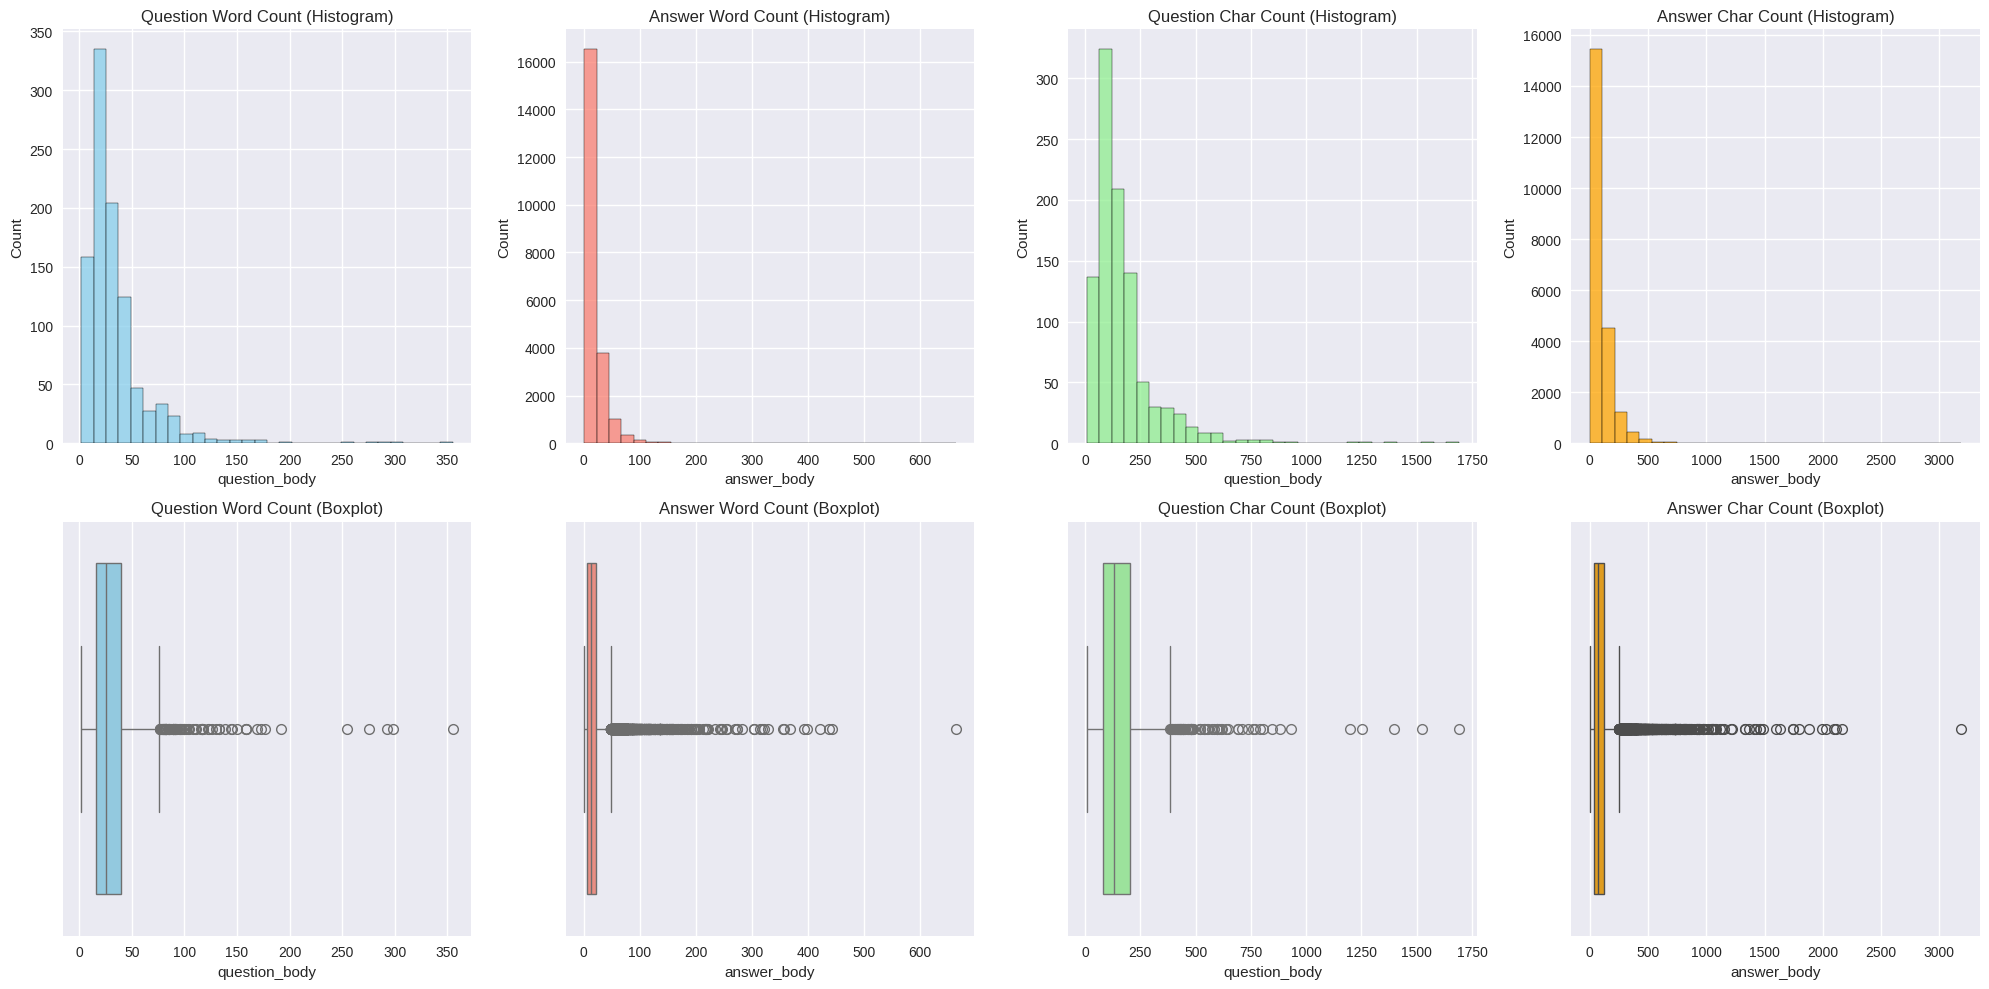

In [54]:
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(question_word_lens, bins=30, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Question Word Count (Histogram)")
sns.histplot(answer_word_lens, bins=30, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title("Answer Word Count (Histogram)")

sns.boxplot(x=question_word_lens, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title("Question Word Count (Boxplot)")
sns.boxplot(x=answer_word_lens, ax=axes[1, 1], color='salmon')
axes[1, 1].set_title("Answer Word Count (Boxplot)")

sns.histplot(question_char_lens, bins=30, ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title("Question Char Count (Histogram)")
sns.histplot(answer_char_lens, bins=30, ax=axes[0, 3], color='orange')
axes[0, 3].set_title("Answer Char Count (Histogram)")

sns.boxplot(x=question_char_lens, ax=axes[1, 2], color='lightgreen')
axes[1, 2].set_title("Question Char Count (Boxplot)")
sns.boxplot(x=answer_char_lens, ax=axes[1, 3], color='orange')
axes[1, 3].set_title("Answer Char Count (Boxplot)")

plt.tight_layout()
plt.show()


## **<span style="color: #808080;">Identify the most engaging questions</span>**

In [55]:
answer_counts = df.groupby("question_id")["answer_id"].count().sort_values(ascending=False)

top_questions = answer_counts.head(10)
print("Top 10 Most Answered Questions:\n", top_questions)

Top 10 Most Answered Questions:
 question_id
1556257    315
1577970    313
1555428    215
1559359    215
1578477    166
1569562    144
1591164    143
1567278    137
1585904    137
1575297    136
Name: answer_id, dtype: int64


In [56]:
topic_stats = df.groupby('question_subject').agg(
    num_questions=('question_id', 'nunique'),
    total_answers=('answer_id', 'count'),
)

topic_stats = topic_stats.sort_values(by='total_answers', ascending=False).reset_index()


In [57]:
topic_stats.head(10)

,question_subject,num_questions,total_answers
0,با ١٥ ميليون چه چزایی برای جهازتون ميخرين؟,1,315
1,خواندن عقد توسط سید محمد خاتمی,1,313
2,کیا طلاق گرفتن...,1,215
3,گواهی سلامت برم بگیرم ؟,1,215
4,خواستگار,3,181
5,نامزدی,2,171
6,اونایی که شوهراشون خیلی نازشونو میکشه بیان,1,166
7,میخوام یه چی به شوهرم بگم ولی نمیتونم.,1,144
8,شوهرتون ماشین بخره به نامتون نزنه ناراحت میشید؟,1,143
9,خواستم به خواستگارم بگم بیماری دارم اما....,1,137


## **<span style="color: #808080;">Analyze user activity patterns:</span>**

In [58]:
df['answer_date'] = pd.to_datetime(df['answer_date'], errors='coerce')

In [59]:
df['hour'] = df['answer_date'].dt.hour
df['weekday'] = df['answer_date'].dt.day_of_week

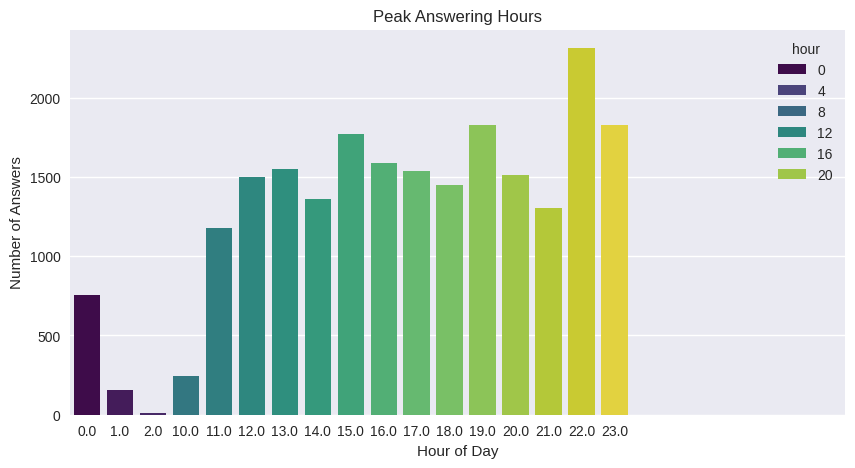

In [60]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hour', hue='hour', palette='viridis')
plt.title('Peak Answering Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Answers')
plt.xticks(range(24))
plt.grid(True, axis='y')
plt.show()

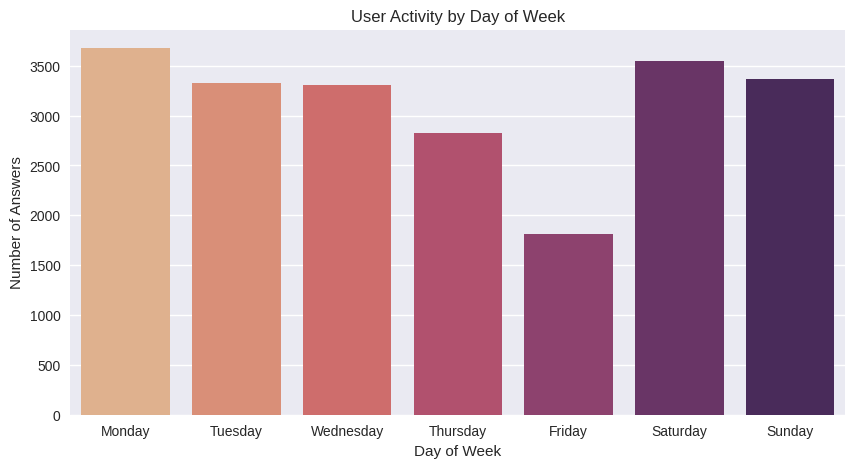

In [61]:
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='weekday', hue='weekday', palette='flare', legend=False)
plt.title('User Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Answers')
plt.xticks(ticks=range(7), labels=day_labels)
plt.grid(True, axis='y')
plt.show()

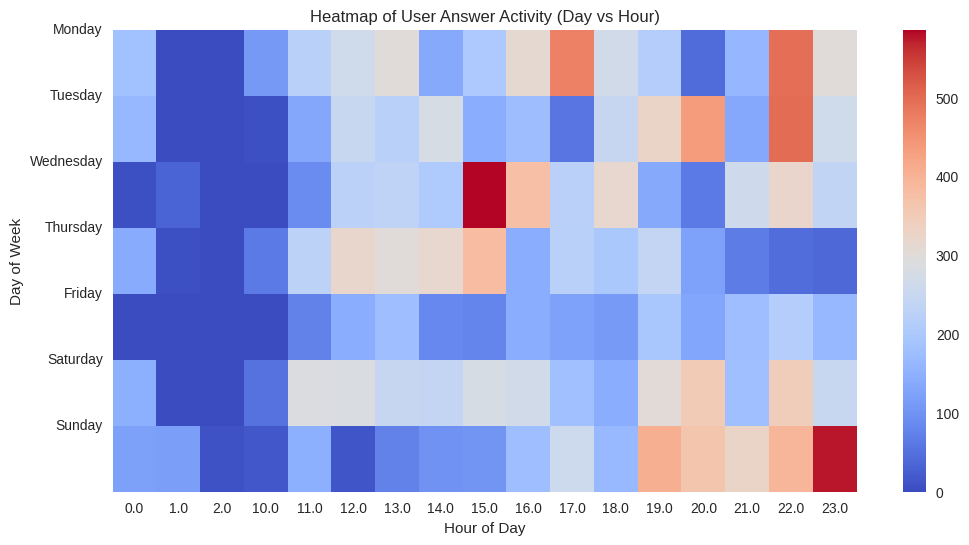

In [62]:
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Heatmap of User Answer Activity (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=day_labels, rotation=0)
plt.show()

## **<span style="color: #808080;">Detect top answer contributors</span>**

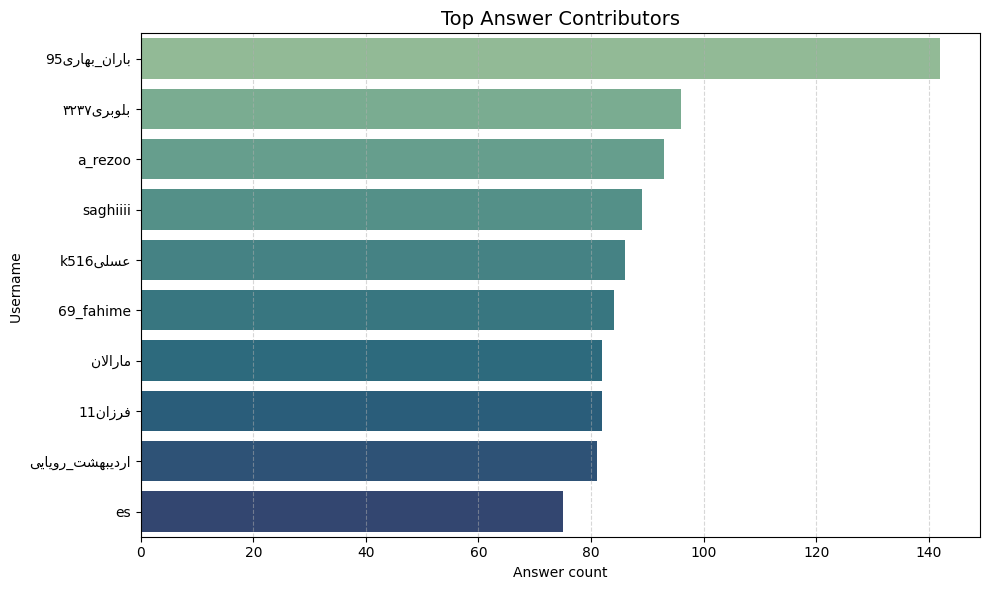

In [7]:
top_users = df['answer_user'].value_counts().head(10)
reshaped_labels = [reshape_and_display_persian(user) for user in top_users.index]

# plt.rcParams['font.family'] = ['sans-serif']
# plt.rcParams['font.sans-serif'] = ['Vazir.ttf']


plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=reshaped_labels, hue=reshaped_labels, palette='crest')

plt.title('Top Answer Contributors', fontsize=14)
plt.xlabel('Answer count')
plt.ylabel('Username ')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **<span style="color: #808080;">Linguistic and word-level analysis</span>**

### **Extract most frequent words**

In [9]:
question_words = [word for tokens in df['question_tokens'].dropna() for word in ast.literal_eval(tokens) if word not in {'.', '،', '؟'}]
answer_words = [word for tokens in df['answer_tokens'].dropna() for word in ast.literal_eval(tokens) if word not in {'.', '،', '؟'}]

q_word_freq = Counter(question_words)
a_word_freq = Counter(answer_words)

print("Top Question Words:", q_word_freq.most_common(10))
print("Top Answer Words:", a_word_freq.most_common(10))


Top Question Words: [('یه', 7151), ('داشت', 6378), ('میشه', 5079), ('داره', 5000), ('الان', 4855), ('زد', 4714), ('باشه', 4589), ('گرفت', 4587), ('نامزد', 4585), ('هست', 4567)]
Top Answer Words: [('یه', 3015), ('داشت', 2503), ('میشه', 2049), ('کن', 2000), ('داره', 1868), ('..', 1852), ('دیگه', 1844), ('بچه', 1805), ('عزیز', 1786), ('الان', 1668)]


### **Plot word frequencies**

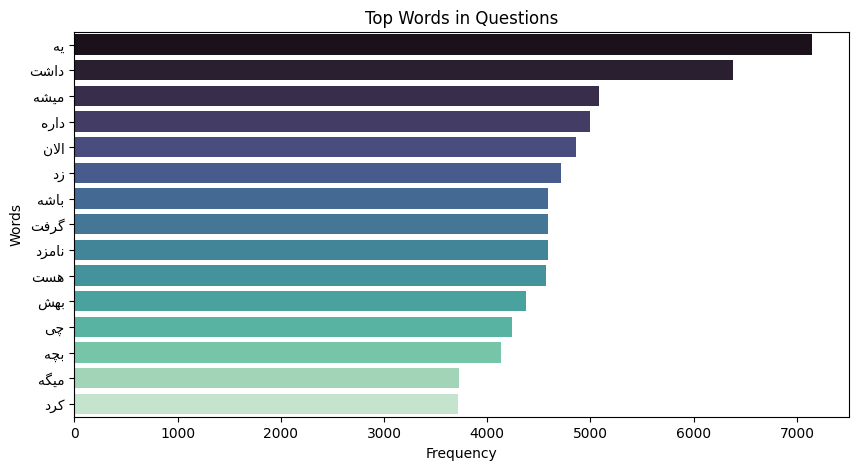

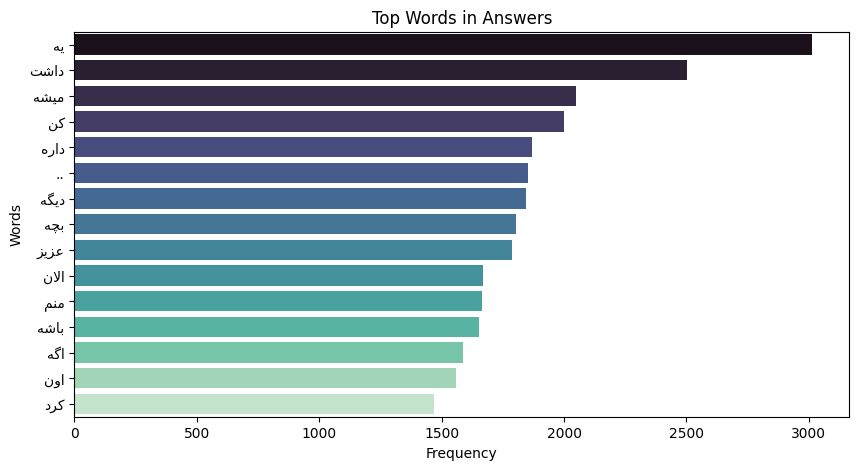

In [11]:
def plot_top_words(word_freq, title, n=15):
    filtered = [(word, freq) for word, freq in word_freq.most_common(n*2)]
    top = filtered[:n]

    words, freqs = zip(*top)

    reshaped_words = [reshape_and_display_persian(word) for word in words]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(reshaped_words), hue=list(reshaped_words), palette="mako")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

plot_top_words(q_word_freq, "Top Words in Questions")
plot_top_words(a_word_freq, "Top Words in Answers")


### **Generate Word Clouds**

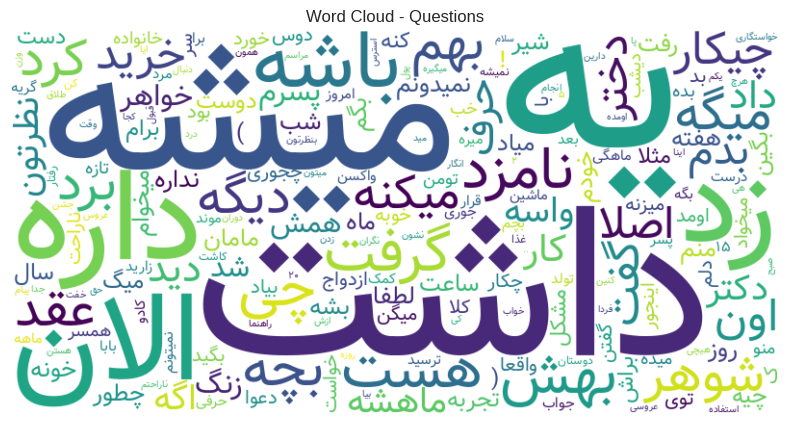

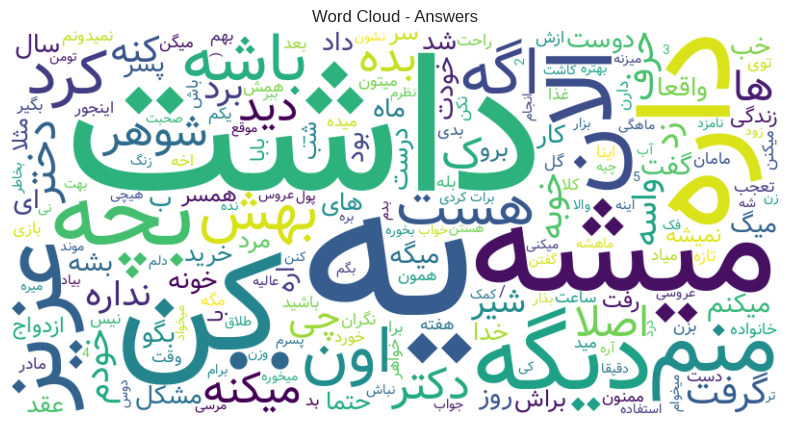

In [66]:
def show_wordcloud(freq, title):
    wc = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=400)
    wc.generate_from_frequencies(freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_wordcloud(q_word_freq, "Word Cloud - Questions")
show_wordcloud(a_word_freq, "Word Cloud - Answers")


### **N-gram Analysis**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(texts, ngram_range=(1, 1), top_n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X = vectorizer.fit_transform(texts)
    sum_words = X.sum(axis=0)
    freqs = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)
    return freqs[:top_n]


#### **Before remove the stopwords**

In [13]:
df['clean_question_str'] = df['question_tokens_with_stopwords'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))
df['clean_answer_str'] = df['answer_tokens_with_stopwords'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))

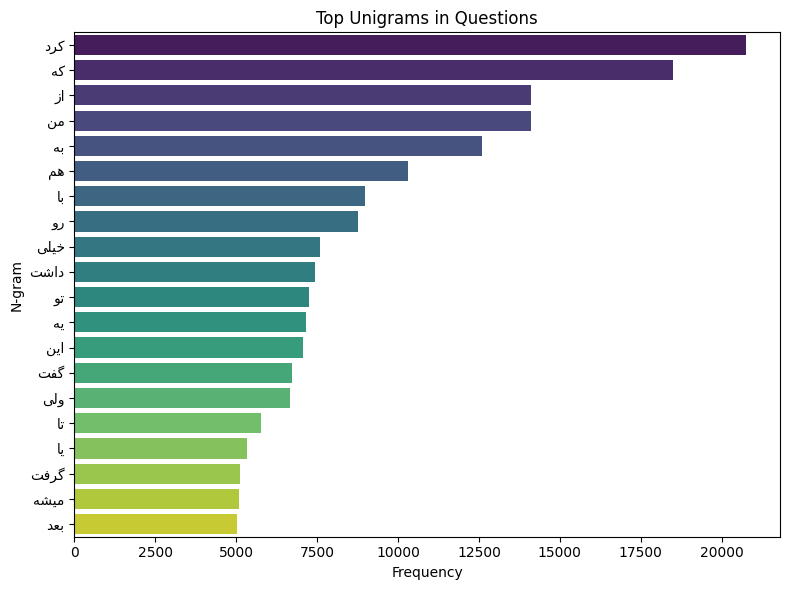

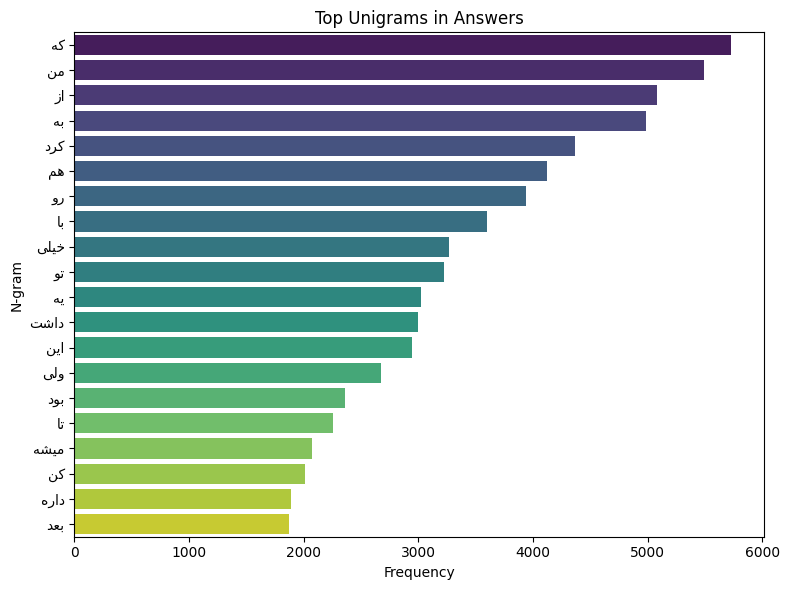

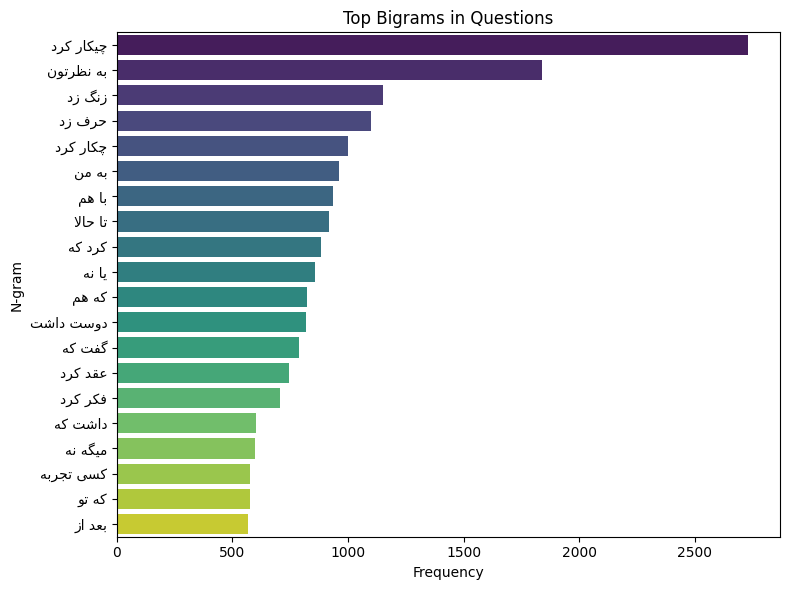

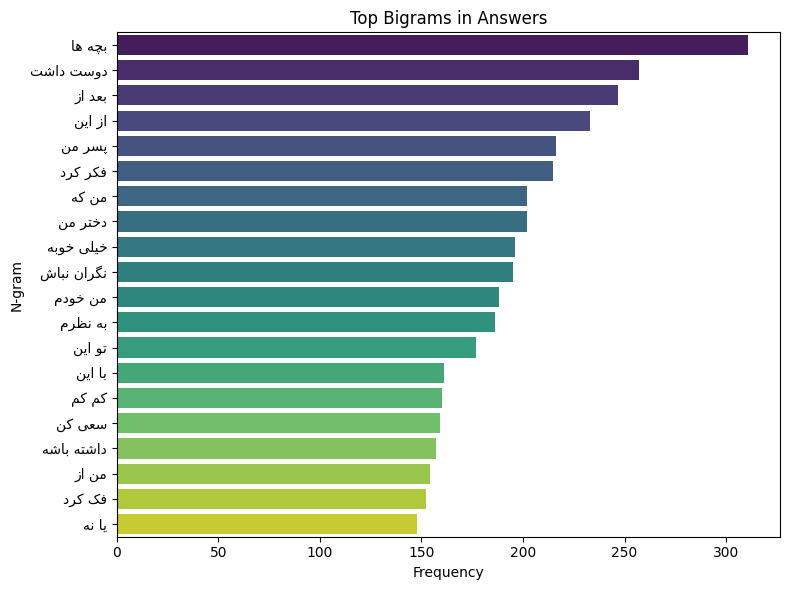

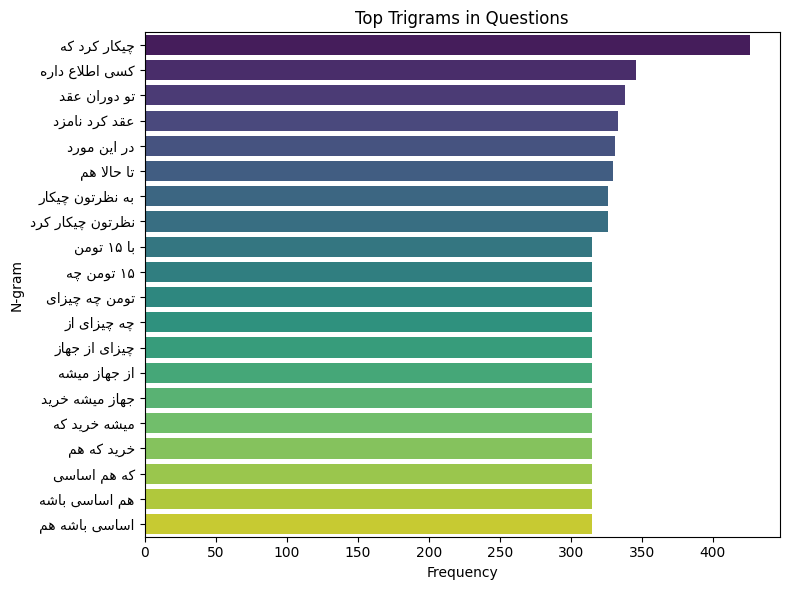

/tmp/ipykernel_16299/2919658540.py:9: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/erfan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


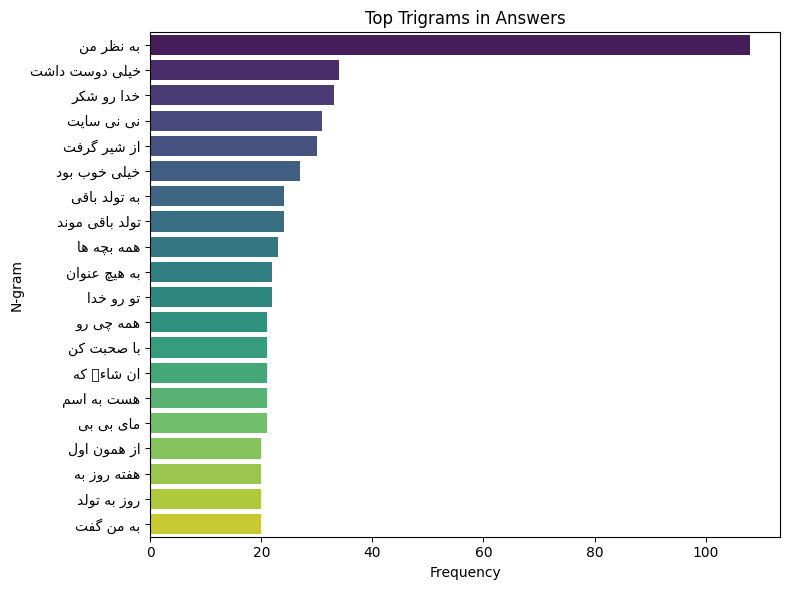

In [14]:
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    reshaped_phrases = [reshape_and_display_persian(phrase) for phrase in phrases]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(freqs), y=reshaped_phrases, hue=reshaped_phrases, palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

q_unigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(1,1))
plot_ngrams(q_unigrams, "Top Unigrams in Questions")

a_unigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(1,1))
plot_ngrams(a_unigrams, "Top Unigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Questions")

q_bigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(3,3))
plot_ngrams(q_bigrams, "Top Trigrams in Questions")

a_trigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(3,3))
plot_ngrams(a_trigrams, "Top Trigrams in Answers")


#### **After remove stopwords**

In [15]:
df['clean_question_str'] = df['question_tokens'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))
df['clean_answer_str'] = df['answer_tokens'].dropna().apply(ast.literal_eval).apply(lambda x: ' '.join(x))

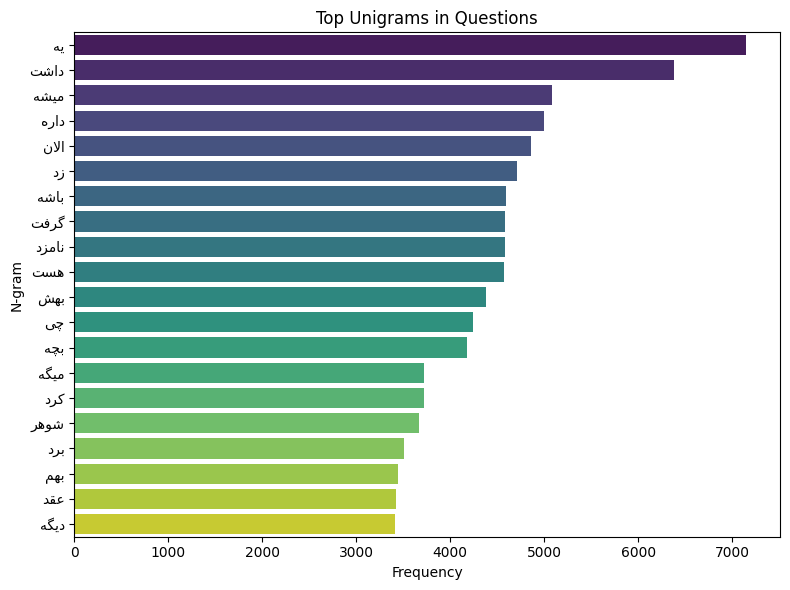

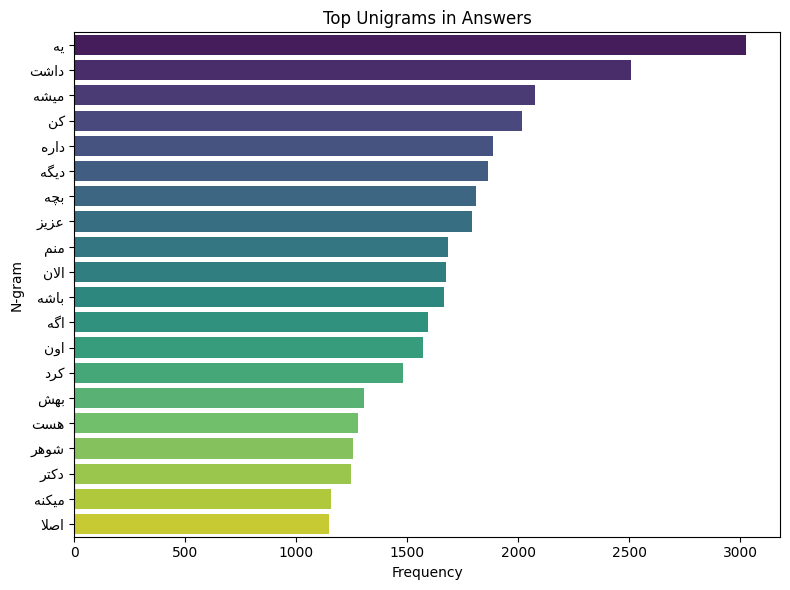

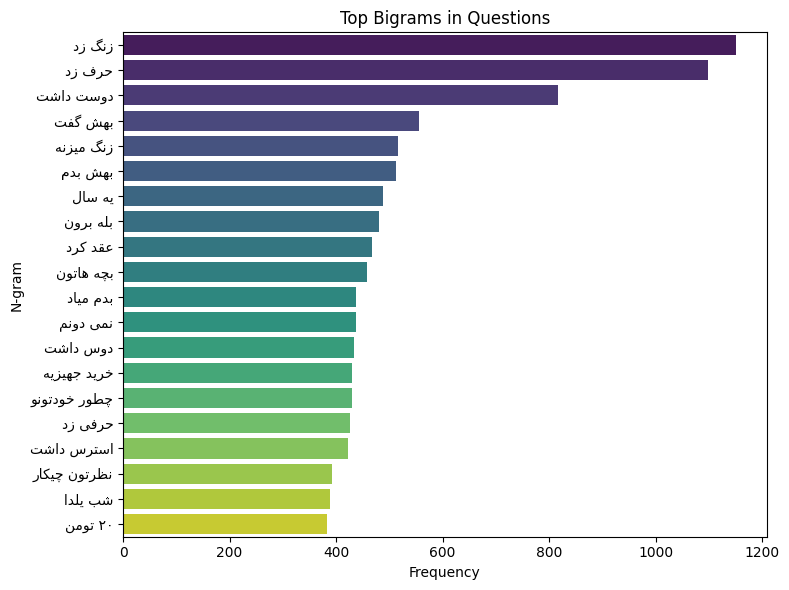

/tmp/ipykernel_16299/2919658540.py:9: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/erfan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


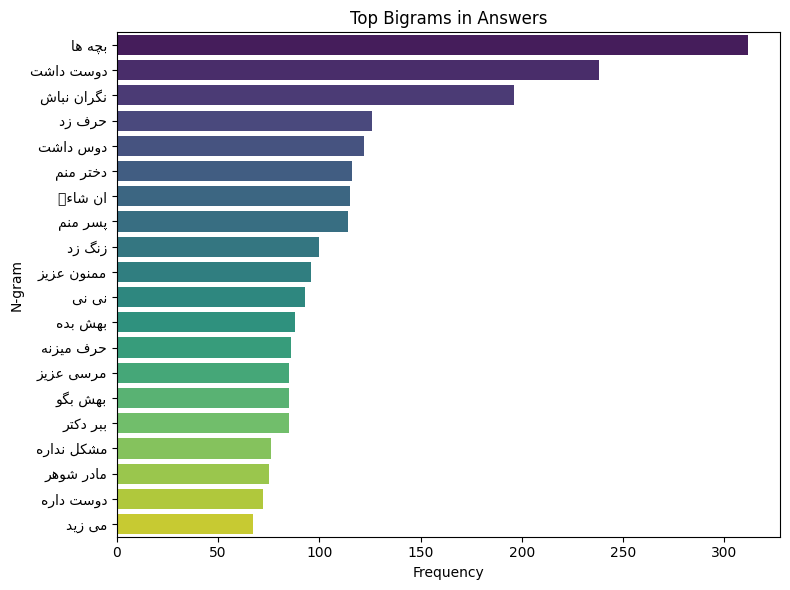

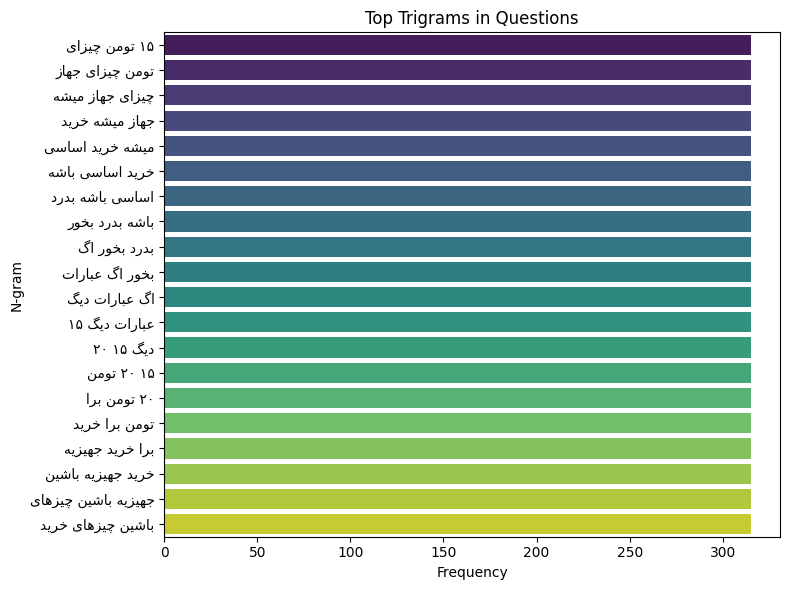

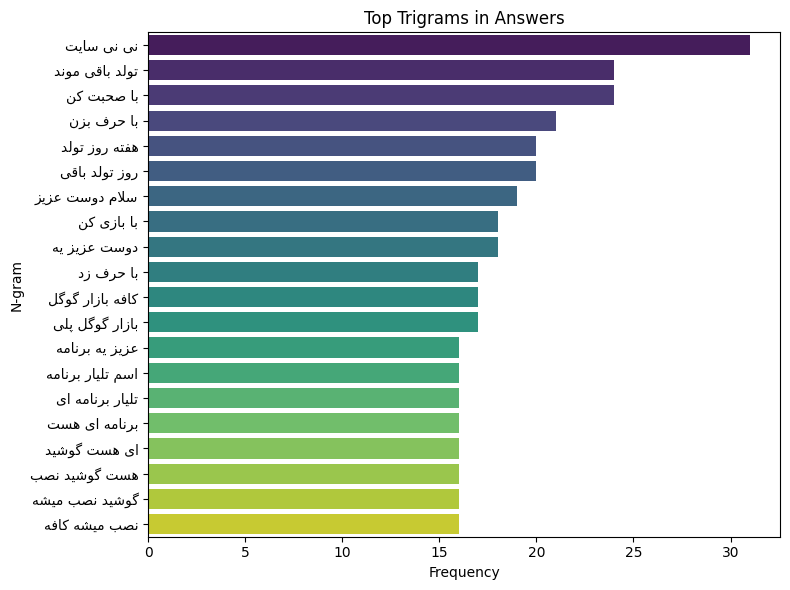

In [16]:
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    reshaped_phrases = [reshape_and_display_persian(phrase) for phrase in phrases]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(freqs), y=reshaped_phrases, hue=reshaped_phrases, palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

q_unigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(1,1))
plot_ngrams(q_unigrams, "Top Unigrams in Questions")

a_unigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(1,1))
plot_ngrams(a_unigrams, "Top Unigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Questions")

q_bigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(2,2))
plot_ngrams(q_bigrams, "Top Bigrams in Answers")

q_bigrams = get_top_ngrams(df['clean_question_str'].dropna(), ngram_range=(3,3))
plot_ngrams(q_bigrams, "Top Trigrams in Questions")

a_trigrams = get_top_ngrams(df['clean_answer_str'].dropna(), ngram_range=(3,3))
plot_ngrams(a_trigrams, "Top Trigrams in Answers")


# **<span style="color: coral;">Analyse the dataset</span>**

## **<span style="color: #808080;">Load preprocessed data</span>**

In [72]:
df = pd.read_csv(PREPROCESSED_DATASET_PATH)
pd.set_option('display.max_colwidth', None)

## **<span style="color: #808080;">Load the bge-m3 embedding model and test it</span>**

In [73]:
sample_row = df.sample(n=1, random_state=20)
QBody = sample_row['clean_question'].to_string(index=False)
sample_row

,question_id,question_subject,question_body,question_user,question_date,question_type,answer_id,answer_body,answer_clean,answer_user,answer_date,gold_label,clean_question,clean_answer,question_tokens,answer_tokens,question_tokens_with_stopwords,answer_tokens_with_stopwords
16180,4393781,برای سیر کردن آخر شب بچه هجده ماهم، سرلاک چه مارکی بخرم؟ مثلا پدیلشور یا گین آپ؟,میخوام سرلاک بخرم وعده اخرشب به پسرم بدم کمتربیداربشه. کدومشون بهترهستن هم وزن گیری هم سیرشدن؟ ۱۸ماهشه یااینکه چیزدیگه میتونم بدم بجاش مثلا پدیلشور یا گین آپ؟,کچ,2020-05-18T21:22:00,General,137438231,. پوره سیب زمینی با شیر ورست کن یکی از شیشه هاشو سرشو یکم قیچی کن بخوره هم کربو هیدرات داره هم کلسیم یا بیسکویت مادر رو باشیر رقیق کن بده یا فرنی حریر بادوم شل بده هم سیر شه هم مقویه ناراحت نشی ها خودم مادرم می دونم غذا خوردن دغدغه همه ی مادر هاست اما سرلاک خداییش از سر باز کنه,پوره سیب زمینی با شیر درست کن یکی از شیشه هاش رو سرش رو یکم قیچی کن بخوره هم کربو هیدرات داره هم کلسیم یا بیسکویت مادر رو باشیر رقیق کن بده یا فرنی حریر بادوم شل بده هم سیر شه هم مقویه ناراحت نشی ها خودم مادرم می دونم غذا خوردن دغدغه همه ی مادر هاست اما سرلاک خداییش از سر باز کنه,دخترتیری,2020-07-17T12:49:10.669245,Good,میخوام سرلاک بخرم وعده اخرشب به پسرم بدم کمتربیداربشه. کدومشون بهترهستن هم‌وزن گیری هم سیرشدن؟ ۱۸ ماهشه یااینکه چیزدیگه میتونم بدم بجاش مثلا پدیلشور یا گین اپ؟,پوره سیب‌زمینی با شیر درست کن یکی از شیشه هاش رو سرش رو یکم قیچی کن بخوره هم کربو هیدرات داره هم کلسیم یا بیسکویت مادر رو باشیر رقیق کن بده یا فرنی حریر بادوم شل بده هم سیر شه هم مقویه ناراحت نشی‌ها خودم مادرم می‌دونم غذا خوردن دغدغه همه‌ی مادر هاست اما سرلاک خداییش از سر باز کنه,"['میخوام', 'سرلاک', 'خرید', 'وعده', 'اخرشب', 'پسرم', 'بدم', 'کمتربیداربشه', '.', 'کدومشون', 'بهترهستن', 'هم\u200cوزن', 'سیرشدن', '؟', '۱۸', 'ماهشه', 'یااینکه', 'چیزدیگه', 'میتون', 'بدم', 'بجا', 'مثلا', 'پدیلشور', 'گین', 'اپ', '؟']","['پوره', 'سیب', 'زمینی', 'شیر', 'درست', 'کن', 'شیشه', 'هاش', 'سرش', 'یکم', 'قیچی', 'کن', 'بخوره', 'کربو', 'هیدرات', 'داره', 'کلسیم', 'بیسکویت', 'مادر', 'باشیر', 'رقیق', 'کن', 'بده', 'فرنی', 'حریر', 'بادوم', 'شل', 'بده', 'سیر', 'شه', 'مقویه', 'ناراحت', 'نش', 'ها', 'خودم', 'مادرم', 'دونم', 'غذا', 'خوردن', 'دغدغه', '', 'مادر', 'هاست', 'سرلاک', 'خدا', 'سر', 'کنه']","['میخوام', 'سرلاک', 'خرید', 'وعده', 'اخرشب', 'به', 'پسرم', 'بدم', 'کمتربیداربشه', '.', 'کدومشون', 'بهترهستن', 'هم\u200cوزن', 'گرفت', 'هم', 'سیرشدن', '؟', '۱۸', 'ماهشه', 'یااینکه', 'چیزدیگه', 'میتون', 'بدم', 'بجا', 'مثلا', 'پدیلشور', 'یا', 'گین', 'اپ', '؟']","['پوره', 'سیب', 'زمینی', 'با', 'شیر', 'درست', 'کن', 'یکی', 'از', 'شیشه', 'هاش', 'رو', 'سرش', 'رو', 'یکم', 'قیچی', 'کن', 'بخوره', 'هم', 'کربو', 'هیدرات', 'داره', 'هم', 'کلسیم', 'یا', 'بیسکویت', 'مادر', 'رو', 'باشیر', 'رقیق', 'کن', 'بده', 'یا', 'فرنی', 'حریر', 'بادوم', 'شل', 'بده', 'هم', 'سیر', 'شه', 'هم', 'مقویه', 'ناراحت', 'نش', 'ها', 'خودم', 'مادرم', 'می', 'دونم', 'غذا', 'خوردن', 'دغدغه', 'همه', '', 'مادر', 'هاست', 'اما', 'سرلاک', 'خدا', 'از', 'سر', 'باز', 'کنه']"


In [74]:
model = BGEM3FlagModel('BAAI/bge-m3')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [75]:
output = model.encode(QBody, return_dense=True, return_sparse=True, return_colbert_vecs=True)

dence_vecs = output.get('colbert_vecs')
lexical_weights = output.get('lexical_weights')
colbert_vecs = output.get('colbert_vecs')

print(f"dence_vecs:\n{output['dense_vecs']}")
print('-'*80)
print(f"lexical_weights:\n{output['lexical_weights']}")
print('-'*80)
print(f"colbert_vecs:\n{output['colbert_vecs']}")

print(colbert_vecs.shape)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dence_vecs:
[-0.006924  0.0186   -0.05096  ... -0.02037   0.0164   -0.0147  ]
--------------------------------------------------------------------------------
lexical_weights:
defaultdict(<class 'int'>, {'232747': 0.0683, '2900': 0.1443, '119321': 0.2778, '41160': 0.1943, '19720': 0.01666, '115464': 0.2338, '83592': 0.1344, '102730': 0.2104, '178': 0.0633, '55015': 0.2496, '376': 0.0745, '165904': 0.1727, '47412': 0.1746, '12721': 0.0642, '4914': 0.1348, '10424': 0.00433, '49876': 0.0942, '20238': 0.1617, '3503': 0.01974, '1149': 0.01369, '37925': 0.2335, '31375': 0.1633, '4145': 0.0632, '193920': 0.08984, '71341': 0.216, '8723': 0.2062, '48094': 0.0834, '1689': 0.02376, '21117': 0.1073, '32253': 0.0702, '383': 0.0312, '10937': 0.0924, '156329': 0.1339, '870': 0.04486, '3955': 0.02722, '8598': 0.07227, '593': 0.05356, '56665': 0.2092, '13020': 0.0375, '323': 0.06964, '38673': 0.2239})
--------------------------------------------------------------------------------
colbert_vecs:
[[-0.04

**outputs:**    
- **dense_vecs**: Dence embedding are vectors where each number represents a feature or aspect of the input data.dence embedding have most of their elements as non-zero values.Dense vectors are excellent for capturing semantic similarity between sentences, paragraphs, or entire documents. They work very well when the goal is to compare the overall meaning of texts, even if they do not share the same terms.

- **lexical_weights**: Sparce embeddings are vector representations where most dimensions have a value of zero, while only a few dimensions are non-zero.shine in domains and scenarios where many rare keywords or specialized terms are present.

- **colbert_vecs**: is a vector search algorithm designed for improved semantic search accuracy and efficiency. Unlike traditional single-vector embeddings, colbert uses a late interaction mechanism and generates multiple vectors (one per token) for both queries and documents, allowing for more nuanced and fine-grained similarity comparisons.

## **<span style="color: #808080;">Install LanceDB and set up an embedding function.</span>**

In [19]:
@register("custom-embedder")
class MyCustomTextEmbedder(TextEmbeddingFunction):
    name: str = "BAAI/bge-m3"

    def __init__(self):
        super().__init__()
        self._model = BGEM3FlagModel(self.name, devices='cpu')
        self._ndims = self._model.encode(["test"], return_dense=True)['dense_vecs'].shape[1]

    def generate_embeddings(self, texts):
        return self._model.encode(texts, return_dense=True)['dense_vecs'].tolist()

    def ndims(self):
        return self._ndims

## **<span style="color: #808080;">Define a schema for your vector database</span>**

In [20]:

registry = EmbeddingFunctionRegistry.get_instance()
stransformer = registry.get("custom-embedder").create()

class TextModelSchema(LanceModel):
    qid: str
    qbody: str = stransformer.SourceField()
    embedding: Vector(stransformer.ndims()) = stransformer.VectorField()

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## **<span style="color: #808080;">Create and populate a LanceDB table</span>**

In [21]:
db = lancedb.connect(URI_LANCEDB)

if os.path.exists(os.path.join(URI_LANCEDB, "MyTable.lance")):
    tbl = db.open_table("MyTable")
else:
    tbl = db.create_table("MyTable", schema=TextModelSchema, exist_ok=True)

    target_df = df[['question_id','question_body']].drop_duplicates()
    target_df = target_df.rename(columns={'question_id': 'qid', 'questioembedded_queryn_body': 'qbody'})
    target_df['qid'] = target_df['qid'].astype(str)

    tbl.add(target_df)

## **<span style="color: #808080;">Perform semantic search with LanceDB</span>**


In [22]:
table = db.open_table("MyTable")

queries = [
    "مریضی کودک",
    "واکسیناسیون نوزادان چه زمانی باید انجام بشه؟",
    "نحوه خواباندن نوزاد بدخواب چطوره؟",
    "نحوه آروم کردن نوزاد",
    "تربیت بچه"]


for query in queries:
    results = table.search(query, query_type='vector').limit(5).to_list()
    print(f"result for ({query}):\n")
    for i in range(0, len(results)):
        print(f"qid: {results[i].get('qid')}\tqbody: {results[i].get('qbody')}")
        print(f"distance: {results[i].get('_distance')}\n")
    print(80 * "-")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


result for (مریضی کودک):

qid: 4444083	qbody: پسرم یک سال و هفت ماهشه قسمت هایی از بدنش دونه قرمز زده انگار که ریخته بیرون یا یک حشره ای  کنده بدنش رو.  بخاطر ویروس میترسم ببرمش دکتر چون کرونا تو بیمارستان شهرمون زیاد شده کسی تجربه داره ؟
distance: 0.7819841504096985

qid: 3218787	qbody: پسرم دیروز تب کرد امروز دونه قرمز زده بدنش بیاین لطفا . تجربه ای دارین؟
distance: 0.7908145785331726

qid: 3490368	qbody: بچم خیلی لاغر شده . مریضی و دندون آبش کرده. یکسال و چهار ماهشه. هیچی نمیخوره فقط شیر خودم . دلم میخواد بچم تپلو باشه. چه کنم؟
distance: 0.8083611726760864

qid: 4012817	qbody: پسرم۱۸ماهشه.  دستش اول قرمز شده بود. فکر کردم سوخته الان بعداز چند روز انگار عفونت کرده. توی این اوضاع کرونا هم نمیخوام ببرمش دکتر. چکارکنم زودخوب شه؟
distance: 0.8150298595428467

qid: 3512662	qbody: الان دو هفته هست که دخترم مریضه.  دو بار بردمش دکتر.  دفعه اول فقط گوشاش عفونت داشت.  چرک خشک کن میدادم که دیدم دوباره تب کرده.  بردم دکتر گفت آنفولانزا گرفته الان ۶ روزه تبش پایین نمیاد تورو خدا هر راهکاری بلدین

## **<span style="color: #808080;">Implement classical full-text search using LanceDB</span>**


In [23]:
table.create_fts_index("qbody", replace=True, use_tantivy=True)

for query in queries:
    results = table.search(query, query_type='fts').limit(5).select(['qid', 'qbody']).to_list()
    print(f"result for ({query}):\n")
    for i in range(0, len(results)):
        print(f"qid: {results[i].get('qid')}\tqbody: {results[i].get('qbody')}")
        print(f"score: {results[i].get('_score')}\n")
    print(80 * "-")


result for (مریضی کودک):

qid: 3490368	qbody: بچم خیلی لاغر شده . مریضی و دندون آبش کرده. یکسال و چهار ماهشه. هیچی نمیخوره فقط شیر خودم . دلم میخواد بچم تپلو باشه. چه کنم؟
score: 6.771430969238281

qid: 3067916	qbody: سلام از زمانی که کودک شروع به راه رفتن میکنه یعنی رفتن سه گام چقد طول میکشه که کودک بتونه کامل راه بره؟ بدون کمک
score: 6.314627170562744

qid: 3850167	qbody:  کارگاه مادر و کودک در کرمان سراغ دارین؟
score: 6.171468257904053

qid: 4022759	qbody: قد کودک پانزده  ماهه رو خوابیده میگیرن یا ایستاده؟ لطفا بگید 
score: 5.870386123657227

qid: 4148776	qbody: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟
score: 5.776448726654053

--------------------------------------------------------------------------------
result for (واکسیناسیون نوزادان چه زمانی باید انجام بشه؟):

qid: 3131251	qbody: برای تقویت هوش بچه 20 ماهه چه کاری باید انجام داد؟ چه بازیهایی باید باهاش کرد؟
score: 11.53962516784668

qid: 3395447	qbody: پسرم فردا واکسن داره لطفا اگه راهنمایی دارین بگین. نمی دو

## **<span style="color: #808080;">Research hybrid search techniques</span>**


### **What is Hybrid Search?**
**Hybrid Search combines traditional kewword-based searching with advanced techniques like NLP, semantic search, and machine learning to deliver more accurate and relevant results.**

### **How Does Hybrid Search Work?**
**Hybrid search operates by integrating traditional keyword-based search, which uses sparse vectors, with a modern semantic search that employs dense vectors, offering a more nuanced and accurate retrieval experience.**

- **Keyword-Based Search (Sparse Vectors)**
- **Semantic Search (Dense Vectors)**
- **Combining Sparse and Dense Vectors**
- **Retrieval and Ranking**
- **Comparing Keyword, Semantic, and Hybrid Search**

### **Why Hybrid Search?**
- **Enhanced Relevance and Precision**: Combines keyword search’s exact matching with semantic search’s contextual understanding, retrieving precise and semantically relevant results.

- **Better Query Handling**: Handles both simple keyword queries and complex natural language queries, improving accuracy and user experience.

- **Comprehensive Results**: Ensures no relevant documents are missed, covering both exact keyword matches and semantically related content.

- **Adaptability**: Dynamically adjusts the weight between keyword matches and semantic relevance, continuously improving with machine learning models.

- **Optimized Performance**: Balances computational load by filtering results with keyword search and fine-tuning with semantic search, enabling scalable performance.

- **Versatility in Applications**: Ideal for enterprise search, e-commerce, digital libraries, and more, catering to diverse and complex queries for better user satisfaction.

for more details: [link](https://bhavikjikadara.medium.com/hybrid-search-implementing-rag-with-lancedb-for-production-applications-d6cd33c75ce4)


## **<span style="color: #808080;">Evaluation methods</span>**


### **Methods:**
- **Precision@k:** Measures the proportion of relevant items among the top-k retrieved results.(avoid false positives)
$$ Precision@k=\frac{Number of relevant documents in top k}{k}$$

- **Recall@k:** Measures the proportion of all relevant items that are included in the top-k results.(avoid false negatives)
$$ Recall@k=\frac{Number of relevant documents retrieved in top k}{Total number of relevant documents in the dataset}$$

- **F1@k:** The harmonic mean of Precision@k and Recall@k, providing a balanced measure that penalizes extreme values in either metric. It is useful when both false positive and false negatives are important to minimize​.
$$ F1@k=\frac{2 * Precision@k * Recall@k}{Precision@k + Recall@k}$$

- **NDCG(Normalized Discounted Cumulative Gain)** Takes into account both the relevance and the ranking position of results, giving higher weight to relevant items appearing earlier in the list.

$$ NDCG@k=\frac{DCC@k}{IDCC@k} $$

    DCG@k (Discounted Cumulative Gain):
$$ DCC@k=\sum_{i=1}^{k} \frac{2^{\text{rel}_i} - 1}{\log_{2}{(i+1)}} $$
    note: rel(i) is relevance score of the item at rank i


    - IDCG@k (Ideal DCG): The DCG of the ideal ranking — where all relevant items are sorted by highest relevance first.

# **<span style="color: coral;">Answer Ranking Enhancement with a Reranker</span>**

## **<span style="color: #808080;">Perform semantic search for 5 user queries using the embedding-based method</span>**

In [81]:
db = lancedb.connect(URI_LANCEDB)

table = db.open_table('MyTable')

queries = [
    "بچم مریض شده",
    "واکسیناسیون نوزادان چه زمانی باید انجام بشه؟",
    "نحوه خواباندن نوزاد بدخواب چطوره؟",
    "نحوه آروم کردن نوزاد",
    "تربیت بچه"]

input_pairs_per_query = {}
for query in queries:
    results = table.search(query, query_type='vector').limit(5).to_list()
    input_pairs = []
    print(f"result for ({query}):\n")
    for i in range(0, len(results)):
        input_pairs.append([query, results[i]['qbody']])
        print(f"qid: {results[i].get('qid')}\tqbody: {results[i].get('qbody')}")
        print(f"distance: {results[i].get('_distance')}\n")
    
    input_pairs_per_query[query] = input_pairs
    print(80 * "-")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


result for (بچم مریض شده):

qid: 3218787	qbody: پسرم دیروز تب کرد امروز دونه قرمز زده بدنش بیاین لطفا . تجربه ای دارین؟
distance: 0.6206427812576294

qid: 3691981	qbody: بچم دوسال و دوماهشه ..چند روزه سرماخورده هی دارو بهش میدم فایده نداره الان که خوابید انگار نمیتونه نفس بکشه مثل اینکه سینه اش پر عفونت هست.  چی بهش بدم بنظرتون؟؟
distance: 0.621784508228302

qid: 3312926	qbody: یه بچه کوچولو دارم وسواس شدید گرفتم رو بیماری ها . دستم عرق میکنه و وسواسم تشدید شده . شوهرم خسته شده میگه دیگه کم اوردم از دستت. همش از بیماری های بد میترسم هپاتیت سی سل تب مالت و .. حالم خیلی بده عاجزم دیگه پیش روانشناس رفتم ولی شوهرم همکاری نمیکنه میگه خسته شدم دیگه . میترسم خودم و دخترم خدایی نکرده مریض شیم . توان مواجهه شدن با چیزایی که میترسم رو ندارم . بچم رو شیر میدم و دارو نمیخوام بخورم. نمیدونم چیکار کنم. حالم خیلی بده
distance: 0.6252406239509583

qid: 3682419	qbody: بچم یهو میاد موهام رو میکشه. نمیدونم چیکار کنم؟  چرا اینکارو میکنه ؟
distance: 0.6302191615104675

qid: 3490368	qbody: بچم خیلی لاغر شده

## **<span style="color: #808080;">Use the reranker to re-rank the top retrieved answers</span>**

In [82]:
from sentence_transformers.cross_encoder import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')

In [83]:
for query, input_pairs in  input_pairs_per_query.items():
    scores = model.predict(input_pairs)
    answers = [input_pairs[i][1] for i in range(0,5)]
    ranked_answers = sorted(zip(answers, scores), key=lambda x: x[1], reverse=True)
    print(f"result for {query}") 
    print("score:\t\t\t\tanswer:")   
    for answer, score in ranked_answers:
        print(f"{score}\t{answer}")   

    print(80 * "-") 


result for بچم مریض شده
score:				answer:
9.101151466369629	بچم خیلی لاغر شده . مریضی و دندون آبش کرده. یکسال و چهار ماهشه. هیچی نمیخوره فقط شیر خودم . دلم میخواد بچم تپلو باشه. چه کنم؟
9.063493728637695	یه بچه کوچولو دارم وسواس شدید گرفتم رو بیماری ها . دستم عرق میکنه و وسواسم تشدید شده . شوهرم خسته شده میگه دیگه کم اوردم از دستت. همش از بیماری های بد میترسم هپاتیت سی سل تب مالت و .. حالم خیلی بده عاجزم دیگه پیش روانشناس رفتم ولی شوهرم همکاری نمیکنه میگه خسته شدم دیگه . میترسم خودم و دخترم خدایی نکرده مریض شیم . توان مواجهه شدن با چیزایی که میترسم رو ندارم . بچم رو شیر میدم و دارو نمیخوام بخورم. نمیدونم چیکار کنم. حالم خیلی بده
8.903721809387207	بچم دوسال و دوماهشه ..چند روزه سرماخورده هی دارو بهش میدم فایده نداره الان که خوابید انگار نمیتونه نفس بکشه مثل اینکه سینه اش پر عفونت هست.  چی بهش بدم بنظرتون؟؟
8.768756866455078	بچم یهو میاد موهام رو میکشه. نمیدونم چیکار کنم؟  چرا اینکارو میکنه ؟
8.265796661376953	پسرم دیروز تب کرد امروز دونه قرمز زده بدنش بیاین لطفا . تجربه ای دارین؟
------

## **<span style="color: #808080;">Compare and report the difference in results before and after reranking</span>**

## Before Reranking:
- **Focus on initial relevance**
- **Potential for noise**
- **Limited Contextual Understanding**

## After Reranking:
- **Enhanced relevance and context**
- **Imporoved Ordering**
- **Limited Contextual Understanding**